# Imports

In [1]:
import openmeteo_requests

from shared_utilities import *

import requests_cache
import pandas as pd
from retry_requests import retry

import matplotlib.pyplot as plt

from openmeteo_sdk.Variable import Variable
from openmeteo_sdk.Aggregation import Aggregation

# Extract

In [2]:
wind_farms = [
    {"name": "Amakhala Emoyeni", "location": [-32.6030, 25.9280]},
    {"name": "Aurora Wind Power", "location": [-32.9141, 17.9911]},
    {"name": "Chaba Wind Farm", "location": [-32.8250, 27.8250]},
    {"name": "Cookhouse Wind Farm", "location": [-32.7494, 25.6931]},
    {"name": "Copperton Windfarm", "location": [-29.9569, 24.7083]},
    {"name": "Dassieklip Wind Energy Facility", "location": [-34.1872, 19.4328]},
    {"name": "Dorper Wind Farm", "location": [-31.4072, 26.3624]},
    {"name": "Excelsior Wind Energy Facility", "location": [-34.0226, 20.4417]},
    {"name": "Garob Wind Farm", "location": [-29.9556, 24.7081]},
    {"name": "Golden Valley Wind", "location": [-32.7955, 25.7254]},
    {"name": "Gouda Wind Project", "location": [-33.3194, 19.1000]},
    {"name": "Grassridge Wind Farm", "location": [-33.7975, 25.6251]},
    {"name": "Jeffreys Bay Wind Farm", "location": [-34.0500, 24.9200]},
    {"name": "Kangnas Wind Farm", "location": [-29.6811, 17.8778]},
    {"name": "Khobab Wind Farm", "location": [-31.3500, 19.7500]},
    {"name": "Kouga Wind Farm", "location": [-34.0472, 24.9225]},
    {"name": "Loeriesfontein 2 Wind Farm", "location": [-30.8865, 19.8085]},
    {"name": "Longyuan Mulilo De Aar Maanhaarberg Wind Energy Facility", "location": [-30.6815, 24.0125]},
    {"name": "Longyuan Mulilo Green Energy De Aar 2 North Wind Energy Facility", "location": [-30.6485, 23.9442]},
    {"name": "Metrowind Van Stadens Wind Farm", "location": [-33.9126, 25.2482]},
    {"name": "Nobelsfontein Phase 1", "location": [-31.3831, 23.1906]},
    {"name": "Nojoli Wind Farm", "location": [-32.8081, 25.6673]},
    {"name": "Noupoort Wind Farm", "location": [-31.6381, 24.8819]},
    {"name": "Nxuba Wind Farm", "location": [-32.7071, 25.7333]},
    {"name": "Oyster Bay Wind Farm", "location": [-34.0261, 24.9467]},
    {"name": "Perdekraal East Wind Farm", "location": [-33.3400, 19.2500]},
    {"name": "Red Cap – Gibson Bay", "location": [-34.0333, 24.9167]},
    {"name": "Roggeveld Wind Farm", "location": [-32.3928, 20.8311]},
    {"name": "Sere Wind Farm", "location": [-31.7500, 18.0833]},
    {"name": "The Karusa Wind Farm", "location": [-32.3906, 20.8242]},
    {"name": "Tsitsikamma Community Wind Farm", "location": [-34.1862, 24.5256]},
    {"name": "Umoya Energy Wind Farm", "location": [-33.0011, 18.3486]},
    {"name": "Waainek Wind Farm", "location": [-33.3042, 26.5247]},
    {"name": "Wesley-Ciskei", "location": [-34.0167, 26.5333]}
]

wind_farms_df = pd.DataFrame(wind_farms)
wind_farms_df[['latitude', 'longitude']] = pd.DataFrame(wind_farms_df['location'].tolist())
wind_farms_df.drop('location', axis=1, inplace=True)
wind_farms_df = wind_farms_df.set_index('name')

Coordinates -32.934974670410156°N 17.977941513061523°E
Elevation 155.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


<Axes: xlabel='timestamp'>

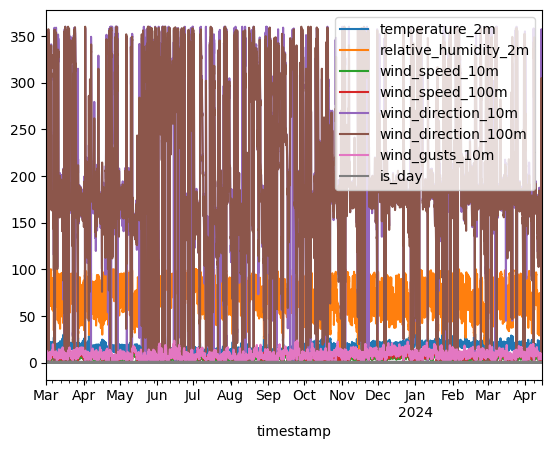

In [14]:
farm = 'Aurora Wind Power'
save = False
latitude = wind_farms_df.loc[farm]['latitude']
longitude = wind_farms_df.loc[farm]['longitude']

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2023-03-01",
	"end_date": "2024-04-16",
	"hourly": ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "is_day"],
	"wind_speed_unit": "ms"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(6).ValuesAsNumpy()
hourly_is_day = hourly.Variables(7).ValuesAsNumpy()

hourly_data = {"timestamp": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["is_day"] = hourly_is_day

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.dropna(inplace = True)

hourly_dataframe.set_index("timestamp", inplace = True)
if save:
	hourly_dataframe.to_csv(f"data\{farm}_hourly.csv")

hourly_dataframe.plot()


In [25]:
farm = 'Aurora Wind Power'
save = False
latitude = wind_farms_df.loc[farm]['latitude']
longitude = wind_farms_df.loc[farm]['longitude']

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"hourly": ["wind_speed_10m", "wind_speed_80m"],
	"wind_speed_unit": "ms",
	"forecast_days": 1,
	"past_days": 6,
	"models": "icon_seamless"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data
hourly = response.Hourly()
hourly_variables = list(map(lambda i: hourly.Variables(i), range(0, hourly.VariablesLength())))
hourly_wind_speed_10m = filter(lambda x: x.Variable() == Variable.wind_speed and x.Altitude() == 10, hourly_variables)

hourly_data = {"timestamp": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
# Process all members
for variable in hourly_wind_speed_10m:
	member = variable.EnsembleMember()
	hourly_data[f"wind_speed_10m_member{member}"] = variable.ValuesAsNumpy()

hourly_forecasted = pd.DataFrame(data = hourly_data)
hourly_forecasted['aggregated'] = hourly_forecasted.filter(like = "wind_speed_10m_member").mean(axis = 1)
hourly_forecasted.set_index("timestamp", inplace = True)
print(hourly_dataframe)

Coordinates -32.75°N 18.25°E
Elevation 155.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           temperature_2m  relative_humidity_2m  \
timestamp                                                         
2023-03-01 00:00:00+00:00       15.248000             92.851303   
2023-03-01 01:00:00+00:00       15.148001             91.648834   
2023-03-01 02:00:00+00:00       14.998000             91.937828   
2023-03-01 03:00:00+00:00       14.648001             94.340324   
2023-03-01 04:00:00+00:00       14.498000             94.641129   
...                                   ...                   ...   
2024-04-14 19:00:00+00:00       17.348000             62.846451   
2024-04-14 20:00:00+00:00       18.198000             58.976711   
2024-04-14 21:00:00+00:00       17.798000             61.292187   
2024-04-14 22:00:00+00:00       17.198000             63.657406   
2024-04-14 23:00:00+00:00       16.148001             68.046951   

                         

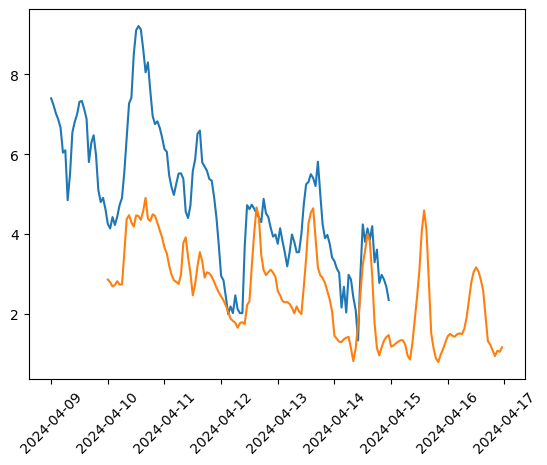

In [27]:
plt.plot(hourly_dataframe[-window_size * 2:]["wind_speed_10m"])
plt.plot(hourly_forecasted['aggregated'])
plt.xticks(rotation = 45)
plt.show()

# Train and load

In [6]:
window_size = 24*3
step = 24

### Univariate or Multivariate Forecasting
column_ = 3                            #
# column_ = None                       #
### Change the column number to select the column to forecast

dm = WeatherDataModule(data_dir='data\Aurora Wind Power_hourly.csv', 
                       window_size=window_size, column=column_,
                       batch_size=32, step_=step, 
                       normalize_=True)

dm.prepare_data()
dm.setup('')

# train(dm= dm, folder='models_OM', train_models=True, load_train=False, rfr=True, xgb_=True, knn=True, ridge=True, window_size=window_size, step=step)
rfr_model, xgb_model, knn_model, ridge_model = load_models(dm = dm, folder='models_2', window_size=window_size, step=step)

Train: torch.Size([6821, 72])
Valid: torch.Size([1949, 72])
Test: torch.Size([974, 72])
Models loaded...


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [08:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


# Validate

MSE for Average model: 0.018727093893755372
MSE for kNN model: 0.025133098
MSE for Ridge model: 0.019090140217985285
MSE for Random Forest model: 0.019329481251513795
MSE for XGBoost model: 0.018619316


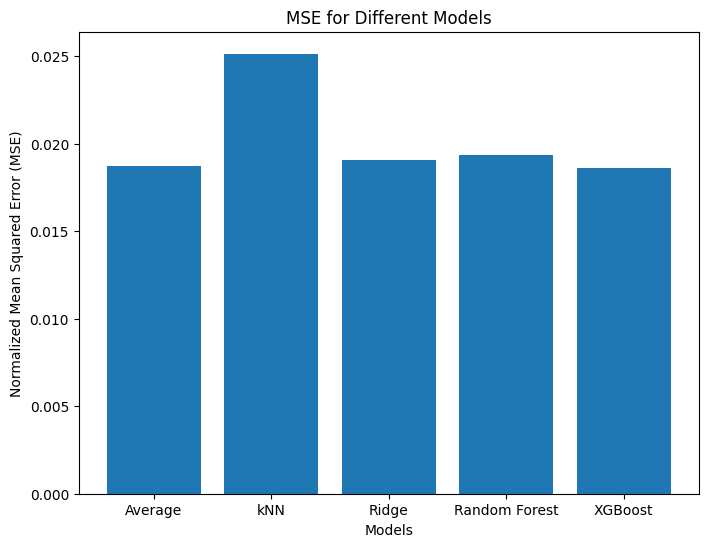

In [7]:
def metrics(column_, X, y, rfr_model, xgb_model, knn_model, ridge_model, window_size, step):    
    weights = [0.25, 0.25, 0.25, 0.25]

    if column_ == None:
        y_true = y[:, :, 2]
    else:
        y_true = y

    X_valid = X.reshape(-1, window_size * dm.df.shape[1])

    y_pred_knn = knn_model.predict(X_valid)
    y_pred_ridge = ridge_model.predict(X_valid)
    y_pred_rfr = rfr_model.predict(X_valid)
    y_pred_xgb = xgb_model.predict(X_valid)
    y_pred_avg = y_pred_rfr * weights[0] + y_pred_xgb * weights[1] + y_pred_knn * weights[2] + y_pred_ridge * weights[3]


    mse_avg = mean_squared_error(y_true, y_pred_avg)
    mse_knn = mean_squared_error(y_true, y_pred_knn)
    mse_ridge = mean_squared_error(y_true, y_pred_ridge)
    mse_rfr = mean_squared_error(y_true, y_pred_rfr)
    mse_xgb = mean_squared_error(y_true, y_pred_xgb)

    # Print MSE for each model
    print("MSE for Average model:", mse_avg)
    print("MSE for kNN model:", mse_knn)
    print("MSE for Ridge model:", mse_ridge)
    print("MSE for Random Forest model:", mse_rfr)
    print("MSE for XGBoost model:", mse_xgb)

    plt.figure(figsize=(8, 6))  
    plt.bar(['Average', 'kNN', 'Ridge', 'Random Forest', 'XGBoost'], [mse_avg, mse_knn, mse_ridge, mse_rfr, mse_xgb])
    plt.xlabel('Models')
    plt.ylabel('Normalized Mean Squared Error (MSE)')
    plt.title('MSE for Different Models')
    plt.show()

metrics(dm.column, dm.f_valid, dm.t_valid, rfr_model, xgb_model, knn_model, ridge_model, window_size, step)

# Inspect

Mean MSE for Random Forest: 8.526611946210938
Mean MSE for XGBoost: 6.2786189107246555
Mean MSE for kNN: 8.922258225803677
Mean MSE for Ridge: 6.017223703160866
Mean MSE for Average: 6.629951862252992


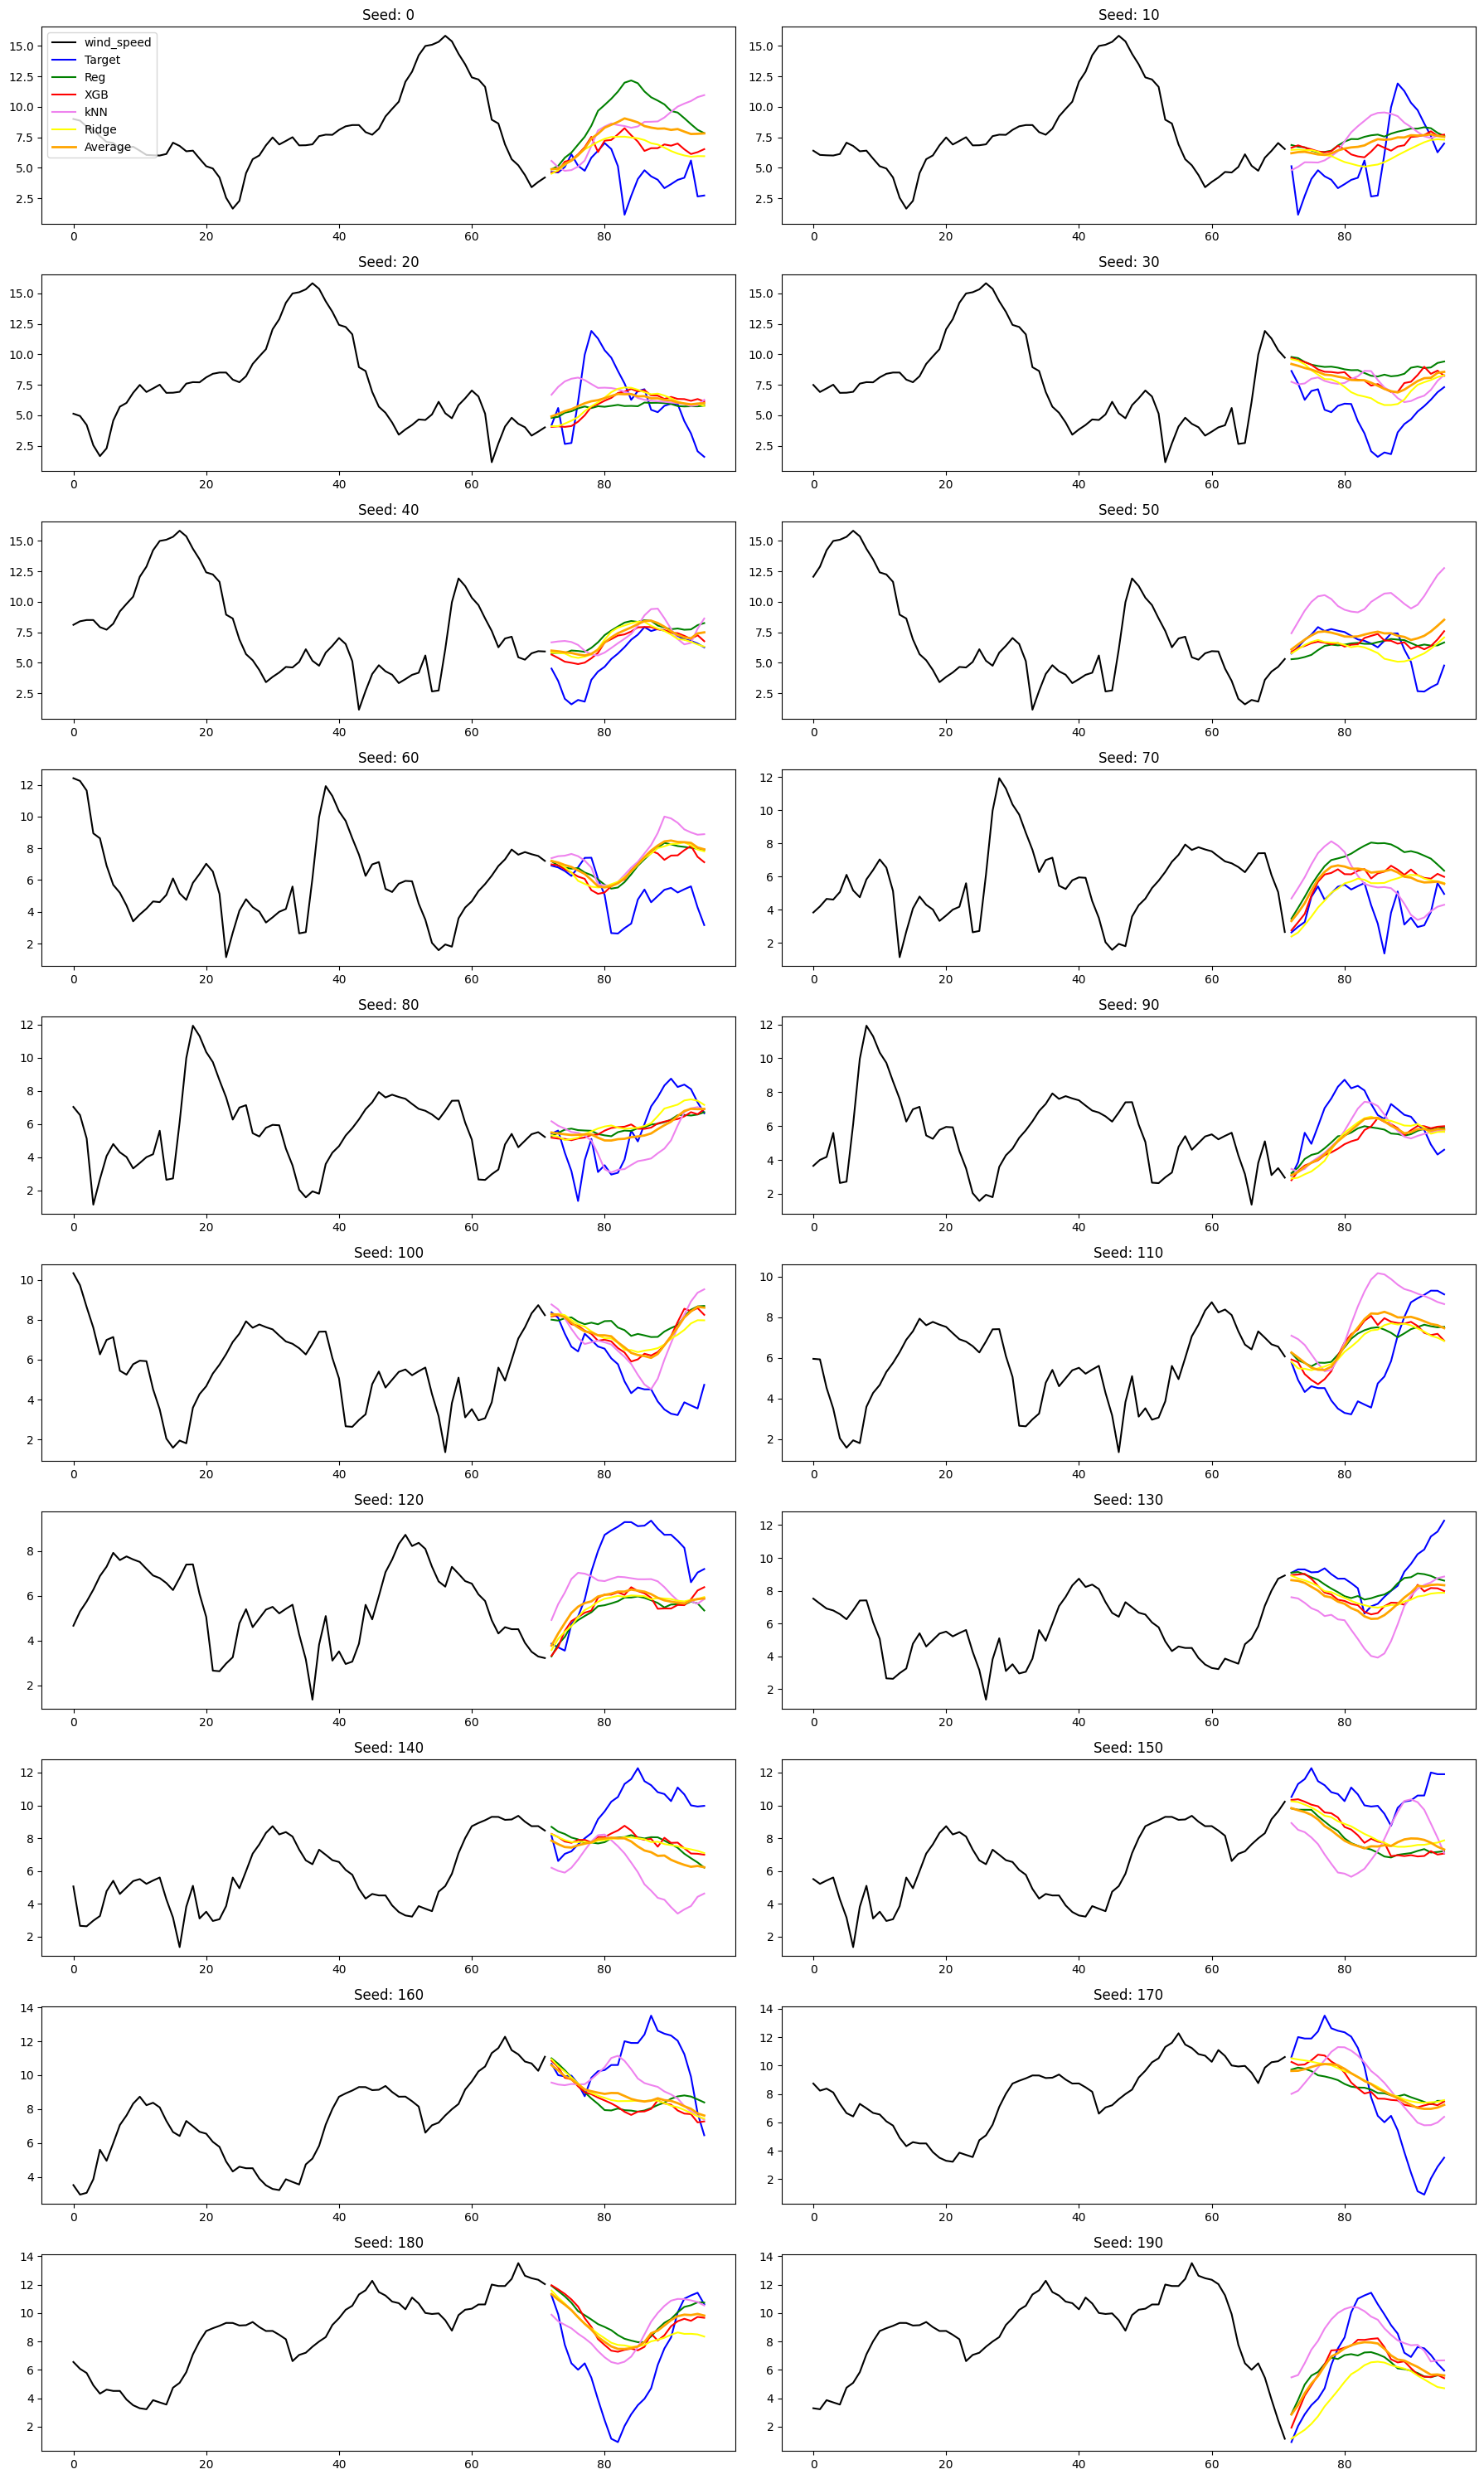

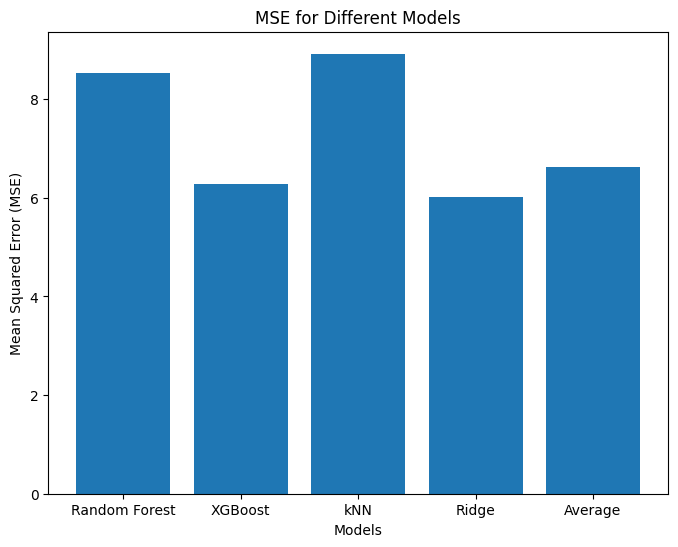

In [8]:
interval = 10

_ = plot_results(seed=0, height=10, width=2, interval=interval, X=dm.f_test, y=dm.t_test,
                 rfr_model= rfr_model, xgb_model=xgb_model, knn_model=knn_model, ridge_model=ridge_model, 
                 plot_features=False, metrics=True, window_size=window_size, step=step, dm=dm) 

MSE for Average model: 0.018156464883187298
MSE for kNN model: 0.024262449
MSE for Ridge model: 0.017718010802122694
MSE for Random Forest model: 0.019189064982682566
MSE for XGBoost model: 0.01815938


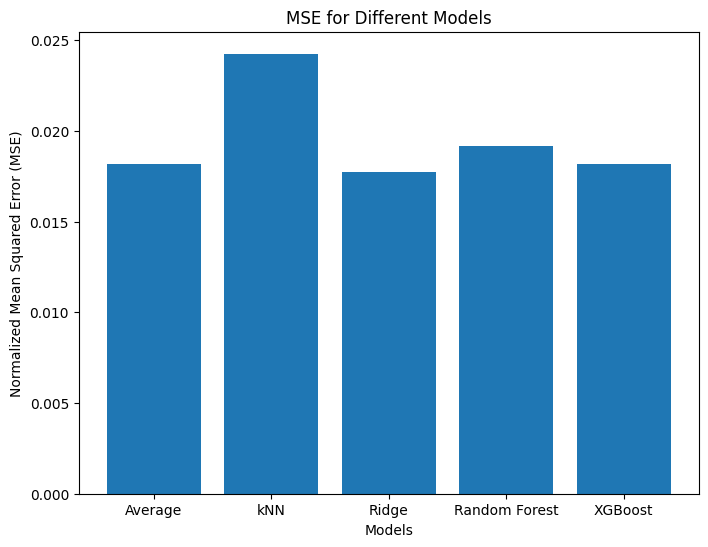

In [9]:
metrics(dm.column, dm.f_test, dm.t_test, rfr_model, xgb_model, knn_model, ridge_model, window_size, step)